In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# header can be used to distinguish the type of nodes
question_header = 'q_'
answer_header = 'a_'
tag_header = 't_'

# This edge list is the intermediate file used for graph building
edges_list_file = "output/tripartite_edges.txt"

# by default, nx creates undirected edges, exactly what we want
G = nx.read_edgelist(edges_list_file, nodetype=str, data=(('weight',float),))
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 1770048
Number of edges: 5744265
Average degree:   6.4905


In [2]:
# General Data Analysis
islands = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("connected components", islands[:10])

connected components [1769770, 8, 5, 5, 4, 4, 4, 4, 4, 4]


In [3]:
# analyze how connected the graph is
# connectivity of 0 again..... oh well
from networkx.algorithms import approximation as approx
approx.node_connectivity(G)

0

## Test Performance
Our random walk algorithm stays the same as bipartite one. In short, we start at a user_node, walk two edges at a time and teleport back to original user node when needed.

Here is why it still works:

Walk two edges:
* if we are at a user\_node, user_node -> question_node -> user_node or tag_node
* if we are at a tag\_node, tag_node -> question_node -> user_node or tag_node
Intuitively, we are using user_node / tag_node as a bridge to go from question to question

Teleportation:
* We will consider teleporting every time random walker is at a user_node / tag_node
* Since user\_node / tag\_node are not question_node, the teleportation still makes sense

Note: While not used currently, we can distinguish user\_node / tag\_node from its header name: `t_` means tag\_node while `a_` means it is user\_node

In [4]:

import random
from collections import Counter

# returns whether x2 - y2 edge is the same as x1 - y1 edge
# is_same_edge(1, 2, 2, 1) == is_same_edge(1, 2, 1, 2) == True
def is_same_edge(x1, y1, x2, y2):
    if x1 == x2:
        return y1 == y2
    elif x1 == y2:
        return y1 == x2
    return False

# a random walk on the user_node (x or y)
# pretend the direct edge (x, y) does not exist
# returns a distribution of questions nodes
def random_walk_on_edge(x, y, teleportation_alpha=0.3, early_stop_threshold=20, n_steps=1000):
    # curr_pos is either user nodes or tag_node
    starting_pos = x if x[:2] == 'a_' else y
    curr_pos = starting_pos
    reacheable_count = Counter()
    for s in range(n_steps):
        try:
            potential_questions_nodes = random.sample(set(G[curr_pos]), 2)
            question_node = potential_questions_nodes[0] if not is_same_edge(x, y, potential_questions_nodes[0], curr_pos) else potential_questions_nodes[1]
            # diff from pinterest algorithm in that we care about questions, not users
            reacheable_count[question_node] += 1
            if sum(reacheable_count.values()) / len(reacheable_count.values()) >= early_stop_threshold:
                # if average > early_stop_threshold, stop
                print('early stopping!')
                break
            potential_user_nodes = random.sample(set(G[question_node]), 2)
            user_node = potential_user_nodes[0] if not is_same_edge(x, y, potential_user_nodes[0], question_node) else potential_user_nodes[1]
            if random.random() < teleportation_alpha:
                curr_pos = starting_pos
            else:
                curr_pos = user_node
        except ValueError:
            # encouter valueError during random.sample when population is smaller than 2
            # This only happens if we reached a deadend
            # simply teleport back
            curr_pos = starting_pos
    # calculate distribution
    tot_visits = sum(reacheable_count.values())
    # sort visits by counts
    all_visits = sorted(reacheable_count.items(), key=lambda x: x[1], reverse = True)
    
    return all_visits, [(i[0], i[1] / tot_visits) for i in all_visits]

In [5]:
all_edges = list(G.edges())
all_edges[:10]

[('a_61', 'q_90'),
 ('a_61', 'q_24270'),
 ('a_61', 'q_47980'),
 ('a_61', 'q_51390'),
 ('a_61', 'q_142340'),
 ('a_61', 'q_526660'),
 ('a_61', 'q_1581560'),
 ('a_61', 'q_2520220'),
 ('a_61', 'q_6242540'),
 ('a_61', 'q_6553950')]

In [6]:
example_u_id = 'a_61'
example_q_id = 'q_90'

print('direct edges from user_id', example_u_id)
print(G[example_u_id])
print(list(G[example_u_id]))
print('direct edges from question id', example_q_id)
print(G[example_q_id])
print(list(G[example_q_id]))

direct edges from user_id a_61
{'q_90': {'weight': 1.0}, 'q_24270': {'weight': 1.0}, 'q_47980': {'weight': 1.0}, 'q_51390': {'weight': 1.0}, 'q_142340': {'weight': 1.0}, 'q_526660': {'weight': 1.0}, 'q_1581560': {'weight': 1.0}, 'q_2520220': {'weight': 1.0}, 'q_6242540': {'weight': 1.0}, 'q_6553950': {'weight': 1.0}}
['q_90', 'q_24270', 'q_47980', 'q_51390', 'q_142340', 'q_526660', 'q_1581560', 'q_2520220', 'q_6242540', 'q_6553950']
direct edges from question id q_90
{'a_61': {'weight': 1.0}, 'a_20709': {'weight': 1.0}, 'a_16012': {'weight': 1.0}, 't_25973': {'weight': 1.0}, 't_19991': {'weight': 1.0}, 't_1182': {'weight': 1.0}, 't_22682': {'weight': 1.0}}
['a_61', 'a_20709', 'a_16012', 't_25973', 't_19991', 't_1182', 't_22682']


In [7]:
# still pretty poor performance. Most visits are those from direct edges
# maybe because it's not converging?
visit, test_distr = random_walk_on_edge(example_u_id, example_q_id)
print(test_distr[:10])
print(visit[:10])
print(len(test_distr))
print([i for i in test_distr if i[0] == example_q_id])

[('q_6242540', 0.048205128205128206), ('q_1581560', 0.04717948717948718), ('q_47980', 0.0441025641025641), ('q_142340', 0.043076923076923075), ('q_24270', 0.043076923076923075), ('q_51390', 0.043076923076923075), ('q_6553950', 0.041025641025641026), ('q_526660', 0.038974358974358976), ('q_2520220', 0.031794871794871796), ('q_12373940', 0.0041025641025641026)]
[('q_6242540', 47), ('q_1581560', 46), ('q_47980', 43), ('q_142340', 42), ('q_24270', 42), ('q_51390', 42), ('q_6553950', 40), ('q_526660', 38), ('q_2520220', 31), ('q_12373940', 4)]
581
[]


## Evaluation

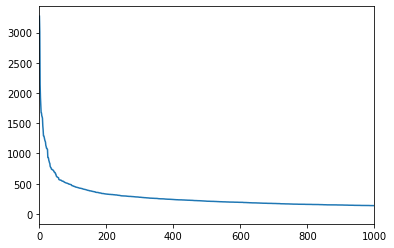

In [8]:
# how many questions do top users answer
matching_nodes = [(curr_node, curr_degree) for curr_node, curr_degree in G.degree if curr_node[:2] == answer_header]
plt.xlim(0, 1000)
plt.plot(sorted([i[1] for i in matching_nodes], reverse=True))
# matching_nodes[:10]

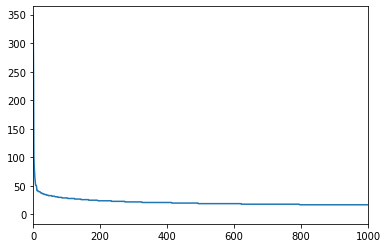

In [9]:
# how many degrees do top questions have
matching_nodes = [(curr_node, curr_degree) for curr_node, curr_degree in G.degree if curr_node[:2] == question_header]
plt.xlim(0, 1000)
plt.plot(sorted([i[1] for i in matching_nodes], reverse=True))
# matching_nodes[:10]

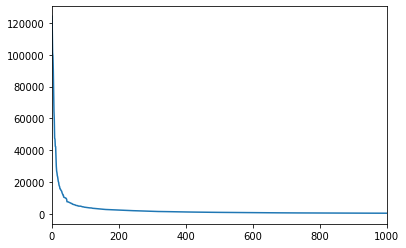

In [10]:
# how many question do top tags have
matching_nodes = [(curr_node, curr_degree) for curr_node, curr_degree in G.degree if curr_node[:2] == tag_header]
plt.xlim(0, 1000)
plt.plot(sorted([i[1] for i in matching_nodes], reverse=True))
# matching_nodes[:10]

## Tune teleport alpha

In [11]:
tune_teleportation_users = [curr_node for curr_node, curr_degree in G.degree if curr_node[:2] == answer_header and curr_degree >= 100]
print(tune_teleportation_users[:5])
print(len(tune_teleportation_users))

tune_teleportation_questions = [random.choice(list(G[curr_user])) for curr_user in tune_teleportation_users]
print(tune_teleportation_questions[:5])

['a_304', 'a_419', 'a_267', 'a_1228', 'a_13']
1653
['q_1259080', 'q_3921010', 'q_56070', 'q_2538430', 'q_18169520']


In [14]:
from multiprocessing import Pool
from tqdm import tqdm
# the range to test alpha on
alpha_range = np.arange(0.1, 0.8, 0.1)

def tune_on_one_alpha(alpha):
    count = 0
    with tqdm(total=len(tune_teleportation_questions)) as pbar:
        for question, user in zip(tune_teleportation_questions, tune_teleportation_users):
            _, test_distr = random_walk_on_edge(user, question, teleportation_alpha = alpha)
            count += len([i for i in test_distr if i[0] == question])>=1
            pbar.update(1)
    return count / len(tune_teleportation_users)

with Pool(len(alpha_range)) as p:
    final_counts = p.map(tune_on_one_alpha, list(alpha_range))
print(final_counts)

2%|▏         | 33/1653 [02:25<1:59:27,  4.42s/it]

  3%|▎         | 45/1653 [02:26<1:26:57,  3.24s/it]
Process ForkPoolWorker-16:

Process ForkPoolWorker-20:


KeyboardInterrupt: 

In [7]:
import numpy as np
final_counts = [0.009679370840895343, 0.016333938294010888, 0.013309134906231096, 0.016333938294010888, 0.013309134906231096, 0.014519056261343012, 0.012099213551119177]
alpha_range = np.arange(0.1, 0.8, 0.1)


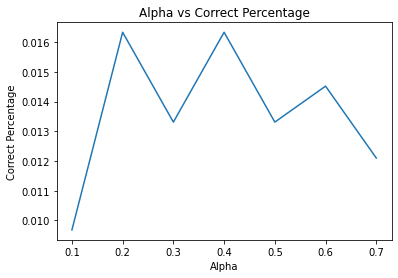

In [8]:
import matplotlib.pyplot as plt
plt.plot(alpha_range, final_counts)
plt.title("Alpha vs Correct Percentage")
plt.xlabel("Alpha")
plt.ylabel("Correct Percentage")
plt.show()